# Hybrid transfer learning for image classification (CIFAR)

This is an example of a hybrid network for image classification, developed according to the *classical-to-quantum transfer learning* scheme presented in [1].

This notebook is inspired by the official PyTorch  [tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by Sasank Chilamkurthy [2].

## General setup

In [ ]:
# install pennylane
!pip install pennylane==0.28

In [17]:
# OpenMP: number of parallel threads.
#%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


### Please choose and run only one of the following two cells, depending on the dataset of interest.

In [253]:
filtered_classes = ['bear', 'tiger']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
quantum = True                    # If set to "False", the dressed quantum circuit is replaced by
                                   # An enterily classical net (defined by the next parameter).
classical_model = '512_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

In [223]:
filtered_classes = ['bear', 'tiger']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
quantum = True                    # If set to "False", the dressed quantum circuit is replaced by
                                   # An enterily classical net (defined by the next parameter).
classical_model = '512_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 3                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

Let us initialize a PennyLane with the default simulator.

In [4]:
dev = qml.device('default.qubit', wires=n_qubits)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset loading

**Remark:** It may take several minutes to download the CIFAR dataset (only the first time).
The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

In [238]:
# Fixed pre-processing operations
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        #transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3, 88
# =================== begin CIFAR dataset loading ===================
trainset_full = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

# CIFAR classes
#class_names = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get indices of samples associated to filtered_classes
filtered_labels=[3, 88]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):
        if label in filtered_labels:
            sub_indices[phase].append(idx)

# Initialize sub-datasets according to filtered indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]
# =================== end CIFAR dataset loading ==========================

# Number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Function to plot images from tensors
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Files already downloaded and verified
Files already downloaded and verified


Let us show a batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

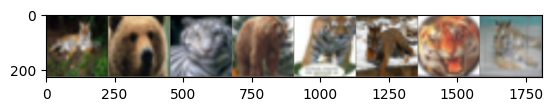

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#imshow(out, title=[class_names[x] for x in classes])
imshow(out)

## Hybrid transfer learning model (classical-to-quantum).

We first define some quantum layers that will compose the quantum circuit.

In [254]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [255]:
@qml.qnode(dev, interface='torch', diff_method="backprop")
def q_net(q_in, q_weights_flat):

        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)

        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)

        # Embed features in the quantum node
        RY_layer(q_in)

        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [256]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features)
            q_in = torch.tanh(pre_out) * np.pi / 2.0

            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

## QCNN


In [104]:
@qml.qnode(dev, interface='torch', diff_method="backprop")
def qcnn(q_in, q_weights_flat):

        # Reshape weights
        q_weights = q_weights_flat.reshape(15, n_qubits)

        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)

        # Embed features in the quantum node
        RY_layer(q_in)

        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k])

        qml.CNOT(wires=[0, 3])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(0))]

In [190]:
class QCNNnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            #self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features)
            q_in = torch.tanh(pre_out) * np.pi / 2.0

            #print('qin size: ', q_in.shape)

            #print('qcirc shape: ', qcnn(q_in[0] ,self.q_params).shape)

            # Apply the quantum circuit to each element of the batch, and append to q_out
            #q_out = torch.Tensor(0, n_qubits)
            q_out = []

            #"""
            for elem in q_in:
                q_out_elem = qcnn(elem, self.q_params).float()
                if q_out_elem > 0:
                  q_out_elem = 1
                else:
                  q_out_elem = 0
                q_out.append(int(q_out_elem))
                #print('qout: ', q_out)
                #q_out_elem = nn.functional.relu(q_out_elem)
                #q_out = q_out_elem
                #q_out = torch.cat((q_out, q_out_elem))
                #q_out = torch.Tensor(q_out)
                #print('qout size: ', q_out.shape)
            #"""
            #return torch.LongTensor(q_out)
            return torch.Tensor(q_out)

In [191]:
model_qcnn = torchvision.models.resnet18(pretrained=True)

for param in model_qcnn.parameters():
    param.requires_grad = False

model_qcnn.fc = QCNNnet()

In [192]:
criterion = nn.BCELoss()
optimizer_hybrid = optim.Adam(model_qcnn.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

In [193]:
def train_qcnn(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train()
                else:
                    # Set model to evaluate mode
                    model.eval()

                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in tqdm(dataloaders[phase]):
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        print('output: ', outputs)
                        #_, preds = torch.max(outputs, 1)
                        print('labels: ', labels)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1

                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss

        # Print final results
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [ ]:
model_qcnn = train_qcnn(model_qcnn, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=5)

## Train the Model

In [257]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512,len(filtered_classes))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [218]:
criterion = nn.CrossEntropyLoss()

We also initialize the *optimizer* which is called at each training step in order to update the weights of the model.

In [219]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every epoch.

In [220]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications).

In [237]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):

            # Each epoch has a training and validation phase
            #for phase in ['train', 'val']:
            for phase in ['train']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train()
                else:
                    # Set model to evaluate mode
                    model.eval()

                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                #for inputs, cifar_labels in tqdm(dataloaders[phase]):
                for inputs, cifar_labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1

                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss

        # Print final results
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

We are ready perform the actual training process.

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=5)

In [60]:
if quantum:
        torch.save(model_hybrid.state_dict(),
            'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
else:
        torch.save(model_hybrid.state_dict(),
            'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file

In [248]:
quantum = True

In [258]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512,len(filtered_classes))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [259]:
if quantum:
    model_hybrid.load_state_dict(torch.load(
        'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

else:
    model_hybrid.load_state_dict(torch.load(
        'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

In [213]:
#model_scripted = torch.jit.script(model_hybrid) # Export to TorchScript
#model_scripted.save('qmodel.pt')

In [265]:
model_hybrid.load_state_dict(torch.load('ep3_acc09.pt'))

<All keys matched successfully>

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [266]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0
model_hybrid.eval()

# Testing loop
for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
    it += 1

# Print final results
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))


Test Loss: 0.3743 Test Acc: 0.9050        


## Visualize the model
Let us compute and the visualize the predictions for a batch of test data.
*Hint:* re-run the next cell to see more samples.

In [262]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, cifar_labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

visualize_model(model_hybrid, num_images=4)


In [263]:
visualize_model(model_hybrid, num_images=4)


## Demo Script

In [251]:
import pickle

def demo(model):

    with open('demo12', 'rb') as fo:
        demodict = pickle.load(fo, encoding='bytes')
    torch.no_grad()
    fig,ax = plt.subplots(3, 4,figsize=(14,9))
    t1=time.time()
    correct=0
    correct_labels=[0]*6+[1]*6
    for i, origdata in enumerate(demodict[b'data']):
        origdata=origdata.reshape((3,32*32)).transpose()
        origdata=origdata.reshape(32,32,3)

######### BELOW:preprocess the origdata for model input and predict using the model #######
######### modify code in this block to predict ######################################
        transform = transforms.Compose(
            [transforms.ToTensor(),
             #transforms.Resize(28, antialias=False),
             transforms.Resize(256),
              transforms.CenterCrop(224),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        data=transform(origdata)
        #data=data.reshape((1,3,28,28))
        data=data.reshape((1,3,224,224))
        output=model(data)
        pred = output.argmax(dim=1, keepdim=True)
        print(type(pred),pred.item(),correct_labels[i])
        if pred.item()==correct_labels[i]:correct+=1
###############################################################################################
###########################  Do not change the code below #####################################
        ax[i//4][i%4].axis('off')
        ax[i//4][i%4].set_title(f'predicted: {filtered_classes[pred]}')
        ax[i//4][i%4].imshow(origdata)
    t2=time.time()
    fig.suptitle('time taken={:6f} sec. Correct images {}'.format(t2-t1,correct),fontsize=16)
    plt.savefig('ex.png')
    plt.ioff()
    plt.show()

<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 1 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 0 0
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 1 1
<class 'torch.Tensor'> 1 1


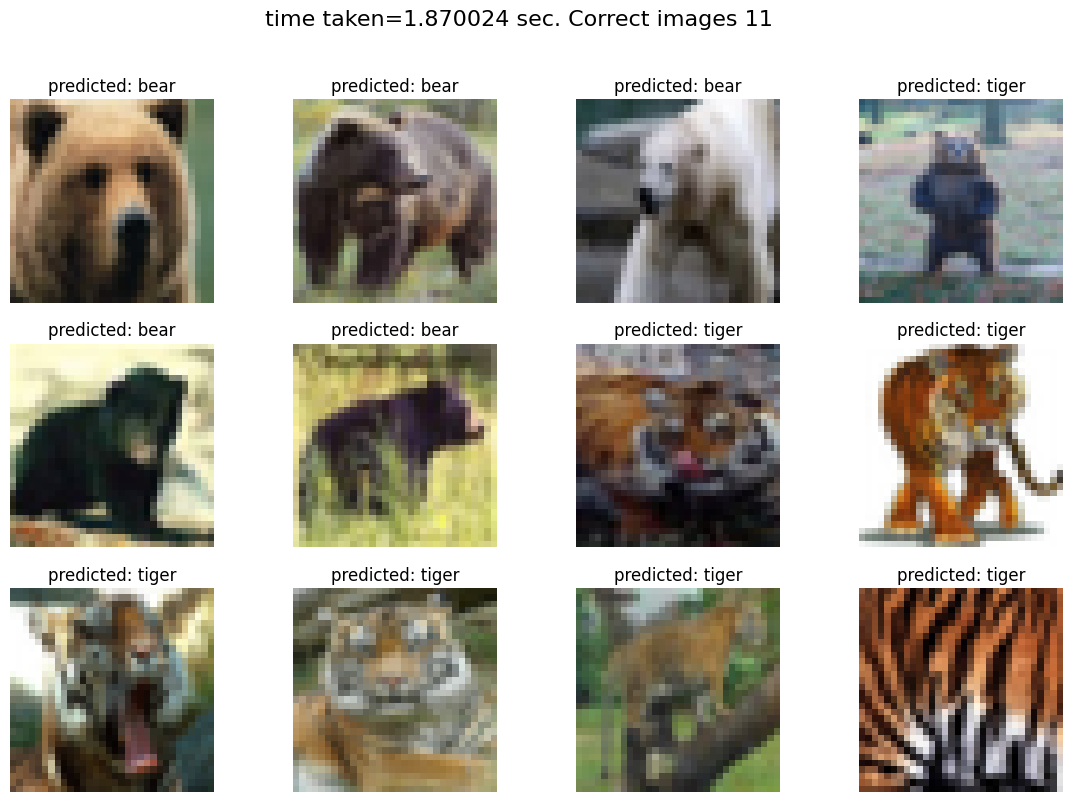

In [270]:
demo(model_hybrid)

## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).
  
[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).

[5] https://github.com/XanaduAI/quantum-transfer-learning/blob/master/c2q_transfer_learning_cifar.ipynb